# FFT-CoCoOp: PEFT Image-Conditioned Prompt Learning for Few-Shot Oxford Flowers-102

- **Author:** Mauro Antonio de Palma
- **Student ID:** 256175

---

**Summary.** CLIP is pretrained to align images and language across hundreds of millions of pairs, yielding strong zero-shot transfer and robustness to distribution shift. End-to-end fine-tuning this entire model on small or domain-specific datasets is often **unnecessary, expensive, and risky**: it can overfit, degrade the carefully learned image–text alignment, and erase CLIP’s hard-won generalization. Parameter-efficient fine-tuning (PEFT) methods keep the pretrained encoders **frozen** and adapt the model by learning a **small number of task-specific parameters**. Among PEFT approaches, **Conditional Context Optimization (CoCoOp)** provides a principled way to adapt CLIP that preserves zero-/few-shot strengths while improving generalization to novel classes.

---

## Limitations of Full Fine-Tuning for CLIP

- **Sample efficiency & overfitting.** Downstream tasks often provide limited supervision. Updating all CLIP parameters (hundreds of millions) increases variance and encourages overfitting, hurting performance on unseen classes and out-of-distribution (OOD) data.
- **Catastrophic interference.** CLIP’s bimodal alignment is a fragile asset: broad weight updates can distort the shared embedding geometry that enables zero-shot transfer and promptability.
- **Compute, memory, and storage.** Full fine-tuning requires high-end hardware, long training times, and saving a full copy of weights per task—costly in multi-task or iterative settings.
- **Reproducibility & maintenance.** Large-scale retuning complicates iteration, rollback, and auditing compared to small, human-readable deltas.

---

## Why PEFT [1] (Prompt/Adapter-Style) Adaptation Is Preferable

PEFT keeps CLIP’s encoders fixed and learns **lightweight knobs** (e.g., prompts). Benefits:

1. **Preserves generalization.** Freezing the encoders maintains the pretrained alignment and zero-shot behavior while enabling task specialization through a small parameter set.
2. **Better bias–variance trade-off.** Fewer trainable parameters reduce the risk of overfitting in low-data regimes.
3. **Efficiency at scale.** Lower GPU memory, faster training using fewer training examples.
4. **Modularity.** Multiple tasks can share the same backbone; swapping tiny adapters/prompts changes behavior without re-training the whole model.

---

## CoOp vs. CoCoOp: Why Conditional Prompts Win [2]

**CoOp** (Context Optimization) learns continuous **context tokens** for textual prompts while keeping CLIP frozen. It reliably outperforms hand-crafted prompts and linear probes in few-shot settings. However, CoOp’s learned **static** context can **overfit to base (seen) classes**, reducing accuracy on **unseen** classes within the same dataset.

**CoCoOp** (Conditional CoOp) addresses this by **conditioning the prompt on the input image**. A lightweight meta-network produces an **instance-dependent token** that is combined with the learned context, yielding **dynamic prompts** that adapt per example. Empirically, CoCoOp:

- **Improves base-to-novel generalization** (higher accuracy on unseen classes) while retaining strong performance on seen classes.
- **Strengthens domain generalization** across datasets.
- **Remains parameter- and data-efficient,** since the encoders stay frozen and only the prompt parameters and a tiny meta-net are learned.

Formally, CLIP classifies by comparing an image embedding **x** with class text embeddings **wᵢ** via cosine similarity and a temperature τ:

$$
p(y \mid \mathbf{x}) \;=\; \frac{\exp\big(\mathrm{sim}(\mathbf{x}, \mathbf{w}_y)/\tau\big)}{\sum_{i=1}^{K} \exp\big(\mathrm{sim}(\mathbf{x}, \mathbf{w}_i)/\tau\big)}.
$$

- **CoOp** learns context vectors that shape **wᵢ** identically for all images.
- **CoCoOp** augments the context with an **image-conditioned token** \(\pi(\mathbf{x})\), so the effective prompt (and thus **wᵢ(\mathbf{x})**) adapts **per instance**, mitigating the seen-class bias that static prompts exhibit.

## 1. Executive Summary - FFT-CoCoOp

As discussed above, the problem is to adapt a pre-trained CLIP model using **few shots on Base classes only**, while keeping **zero-shot performance on Novel classes** high. Report **Base**, **Novel**, and **Harmonic Mean (HM)**.

The proposed method will keep CLIP frozen and form the final text prompt with $2 * n_{ctx} $ learned context tokens obtained by concatenating two $n_{ctx}$-token blocks:
1. An *image-conditioned block* $c_{fft}(x)$ produced by a small MLP that takes in input the 3-channel FFT binned descriptor of the image
2. A *class-agnostic block* $c_{gen}$ produced by a small MLP over learned, image-independent parameters
<br>
A gating sigmoid MLP outputs $g(x) \in (0, 1)$ to blend to the blocks, and the final context is

$$
C(x) = concat \left[ (1 - g(x))·c_{fft}(x), g(x)·c_{gen} \right]
$$

i.e., **(1 - g) FFT tokens** followed by **g generic tokens**.\
$C(x)$ is prepended before the class name and everything is encoded using CLIP's text encoder

> **CLIP text encoder context.** The CLIP text transformer supports a **maximum context length of 77 tokens** (longer inputs are truncated). **Each token is maximum length of 512** ($ctx_{dim} = 512$), and the final text representation is projected into the same 512-dimensional space as the image encoder. When building the prompts (the $2·n_{ctx}$ context tokens + class name), the number of tokens must be lower than 77.


- **Data & split.** Oxford Flowers-102 (official train/val/test). Classes are partitioned **50% Base / 50% Novel** by index; training uses only Base samples, evaluation reports **Top-1** on Base and Novel and **HM**.

- **Backbones.** CLIP **RN50**, **ViT-B/32**, **ViT-B/16** (frozen); only the FFT projector and context tokens are trainable.

- **Expected outcome.** Compared to CLIP zero-shot, FFT-CoCoOp should **raise Base accuracy** with **minimal drop on Novel**, yielding a better **HM** under tight data and compute (e.g., small batch, few epochs).


## 2. Fast Fourier Transform (FFT) [3]: theory & motivation for image-conditioned prompts

### What is the Fourier Transform?
The (discrete) Fourier Transform expresses a signal as a weighted sum of sinusoids (complex exponentials).
For a 1-D discrete signal $x[n]$ of length $N$, the DFT is:
$$
X[k] = \sum_{n=0}^{N-1} x[n]\, e^{-j 2\pi kn/N}, \quad k=0,\dots,N-1.
$$
The **FFT** is an $ \mathcal{O}(N\log N) $ algorithm to compute the same result more efficiently than the naive $ \mathcal{O}(N^2) $.

For a 2-D image $x[m,n]$ of size $H\times W$, the 2-D DFT is separable:
$$
X[u,v] = \sum_{m=0}^{H-1}\sum_{n=0}^{W-1} x[m,n]\; e^{-j2\pi\left(\frac{um}{H}+\frac{vn}{W}\right)}.
$$

### Magnitude vs. phase
- **Magnitude** $|X|$: how much energy exists at each spatial frequency (texture/regularity).
- **Phase** $\angle X$: where structures are located (geometry/layout).
Images with similar textures but different placements have similar magnitude spectra.

### Why frequency features help in few-shot settings
1. **Global texture cues with few parameters.** Radial summaries of $|X|$ (power spectra) capture **global regularities** (e.g., petal striations, leaf venation) with tiny descriptors.
2. **Complement semantic prompts.** CLIP’s text branch encodes **semantic** priors; frequency descriptors contribute **appearance** priors that are relatively agnostic to color shifts and minor spatial changes.
3. **Regularization.** Conditioning prompts on compact FFT descriptors injects image-specific information **without overfitting** to Base classes, because the descriptor is low-dimensional and emphasizes stable global patterns.
4. **Efficiency.** FFT is fast on GPUs/CPUs; a small MLP can project a short descriptor into a handful of prompt tokens.

### Radial power spectrum
After centering the spectrum (`fftshift`), we compute **power** $P=|X|^2$ and **bin it radially** by distance from the DC (zero frequency) component:
- Divide the frequency plane into $B$ rings.
- For each ring, sum (or average) $P$.
This yields a **$B$-dimensional** descriptor per channel.

### Conditioning CLIP prompts with FFT
The radial are mapped to descriptor through a tiny MLP to produce:
- **Context tokens** that are concatenated into the text prompt (before the class name).
- A **gate** $\in(0,1)$ to blend image-conditioned tokens with a small set of learned, class-agnostic tokens.

This makes prompts **image-adaptive**, letting CLIP emphasize textures that matter for the current sample, while keeping the backbone frozen.

**FFT projector MLP**
1. **Linear (Dense) layer** — $B \times 3 \Rightarrow B$
   > The input of this layer is a flattened version of the FFT for each color channel of the image.
2. **ReLU** activation function
3. **Linear (Dense) layer** — $B \Rightarrow n_{\text{ctx}} \times \text{ctx}_{\text{dim}}$

![image](https://github.com/indalaterre/unitn_dl_fft-cocoop/blob/master/data/fft_project_schema.png?raw=true)
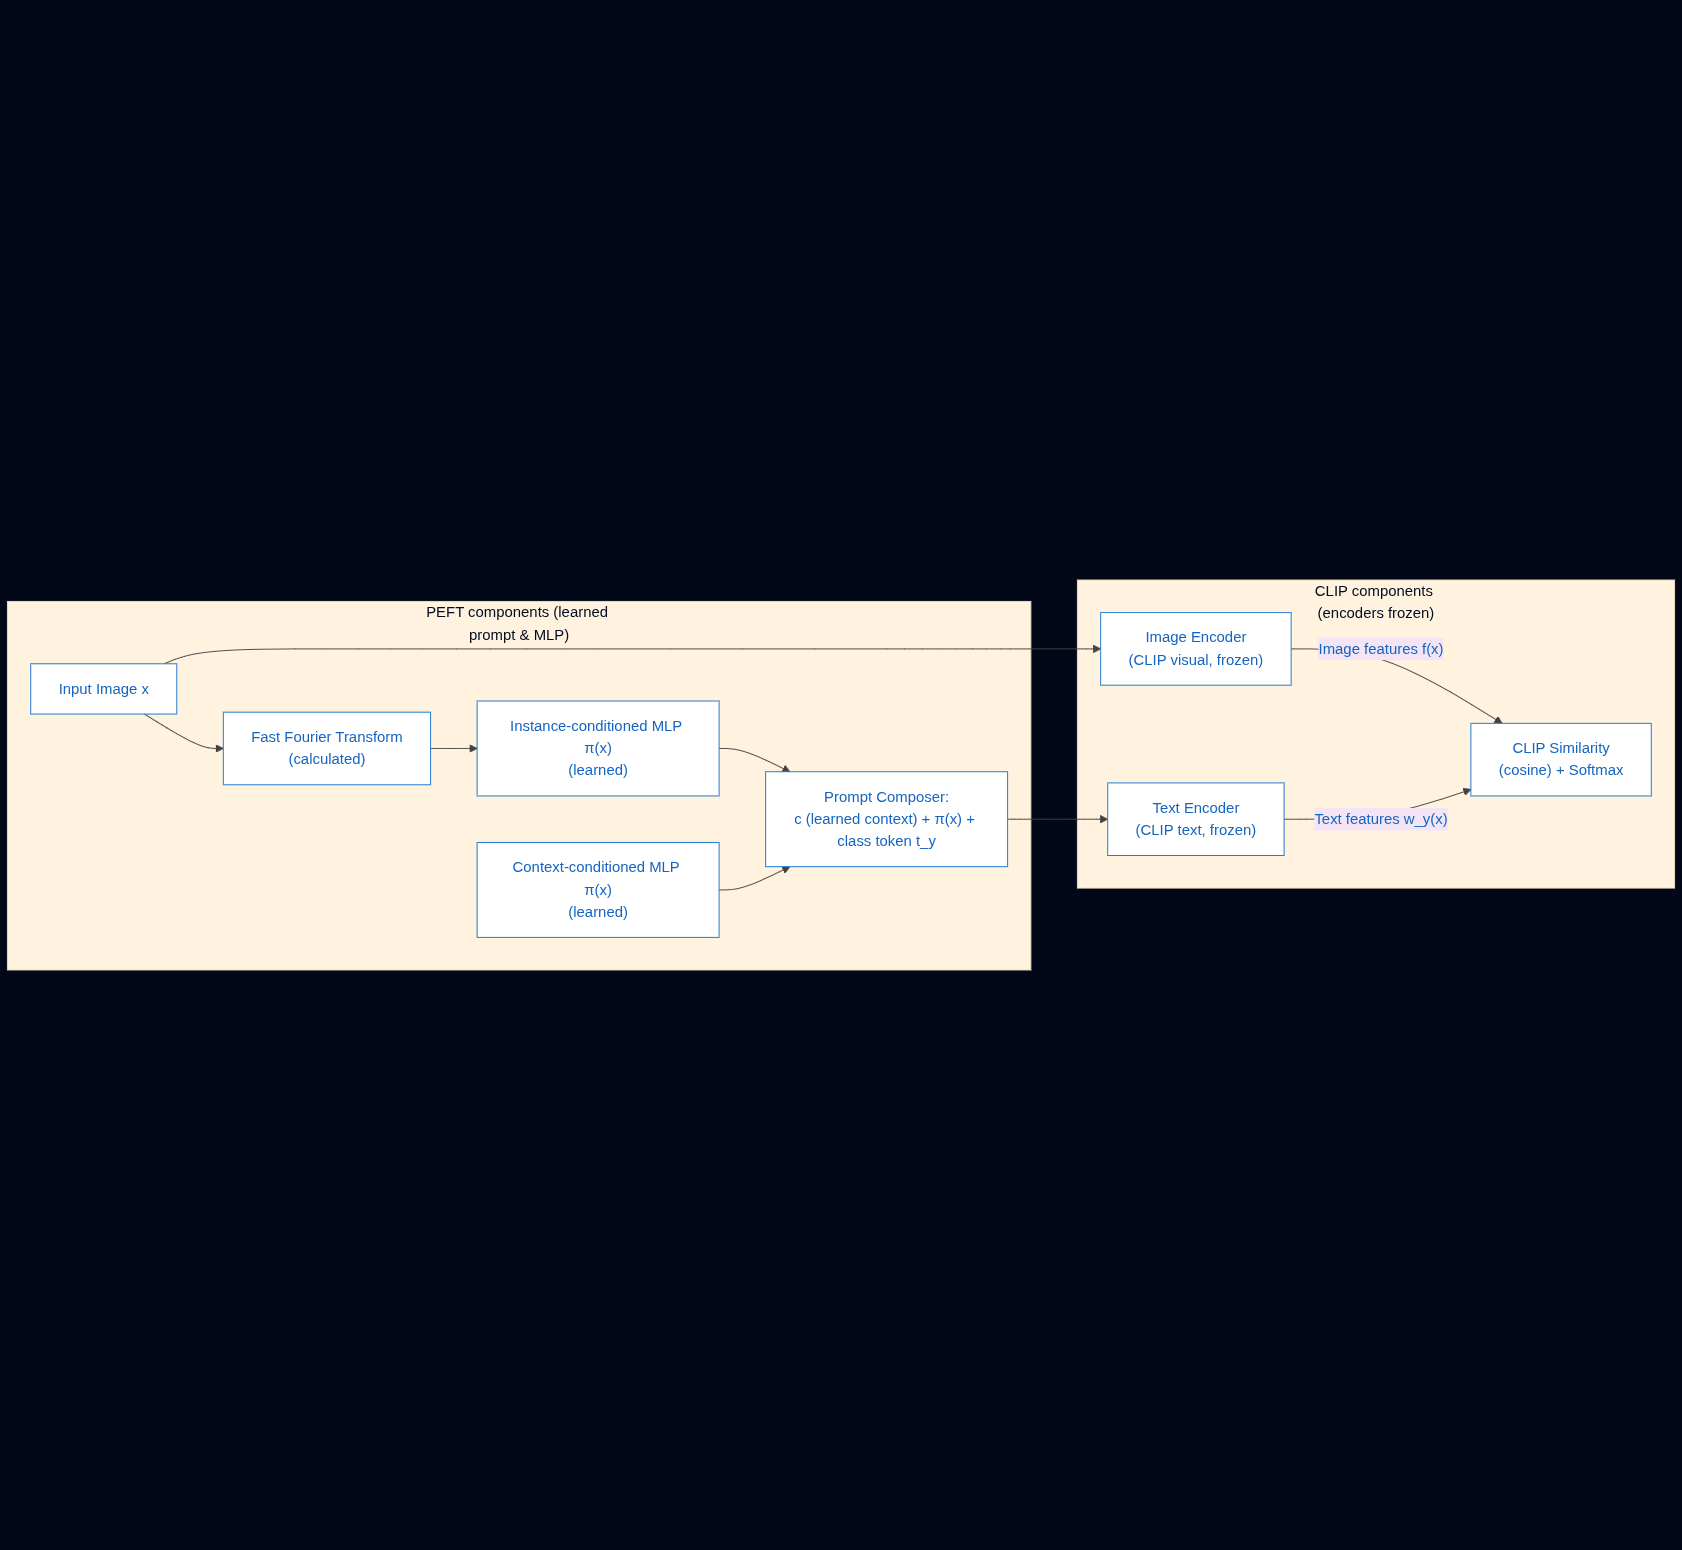

## 3.Dataset & Experimental Protocol

**Dataset.** I've used **Oxford Flowers-102** with the official train/val/test splits. Each image belongs to one of 102 fine-grained flower species.

**Class partition.** The 102 classes are split into two disjoint sets:
- **Base** (seen during adaptation): 50% of classes.
- **Novel** (unseen during adaptation): remaining 50%.

> The partition is deterministic via a fixed random seed so results are reproducible.

**Few-shot regime.** Parameters are trained on **k = 10** images per Base class (the official training split provides 10 per class). No images from Novel classes are used for training.

**Backbone & adaptation.** All CLIP weights (RN50 / ViT-B/32 / ViT-B/16) are initially frozen and then a **lightweight image-conditioned prompt module** using **FFT-based descriptors** of the input image is trained to generate/weight context tokens (FFT-CoCoOp). This keeps the number of trainable parameters small, improving stability with few shots avoiding the curse of dimensionality.

**Evaluation.**
- **Base accuracy $A_\text{base}$:** Top-1 on Base classes.
- **Novel accuracy $A_\text{novel}$:** Top-1 on Novel classes (zero-shot generalization).
- **Harmonic Mean $HM$:**
  $$
  HM = \frac{2 \cdot A_\text{base} \cdot A_\text{novel}}{A_\text{base} + A_\text{novel}}
  $$
Finally reports and metrics on **validation** during development and on **test** will be provided

**Reproducibility.** To make the Base/Novel split deterministic I've set up some seeds for random number generation

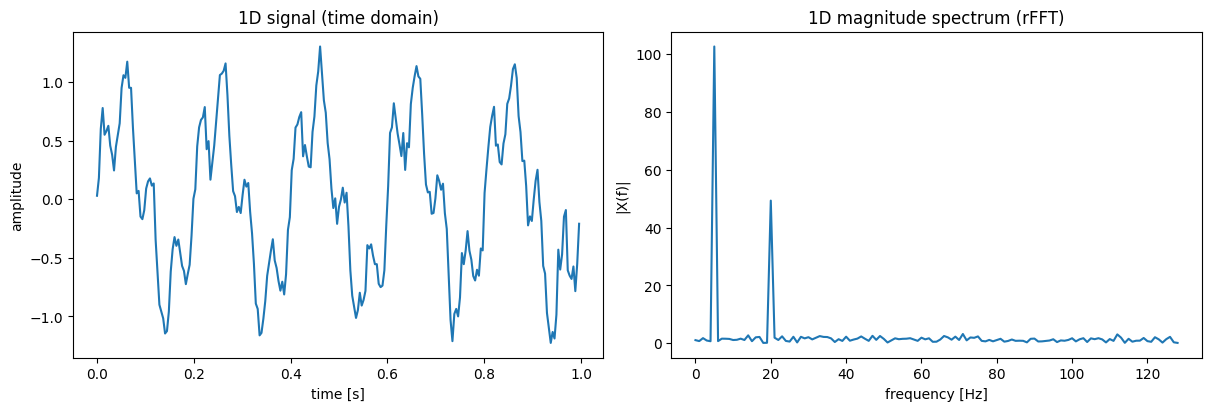

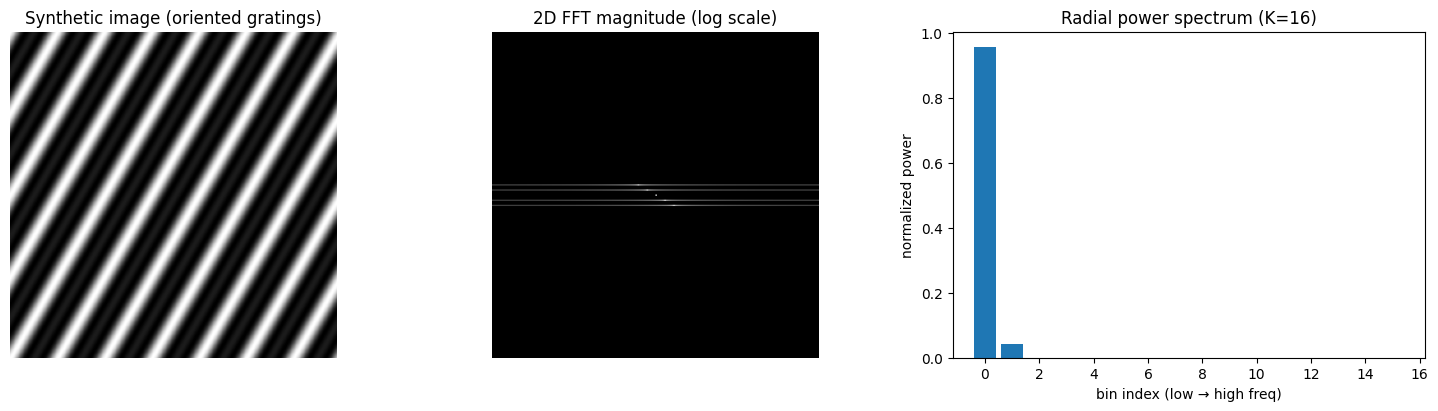

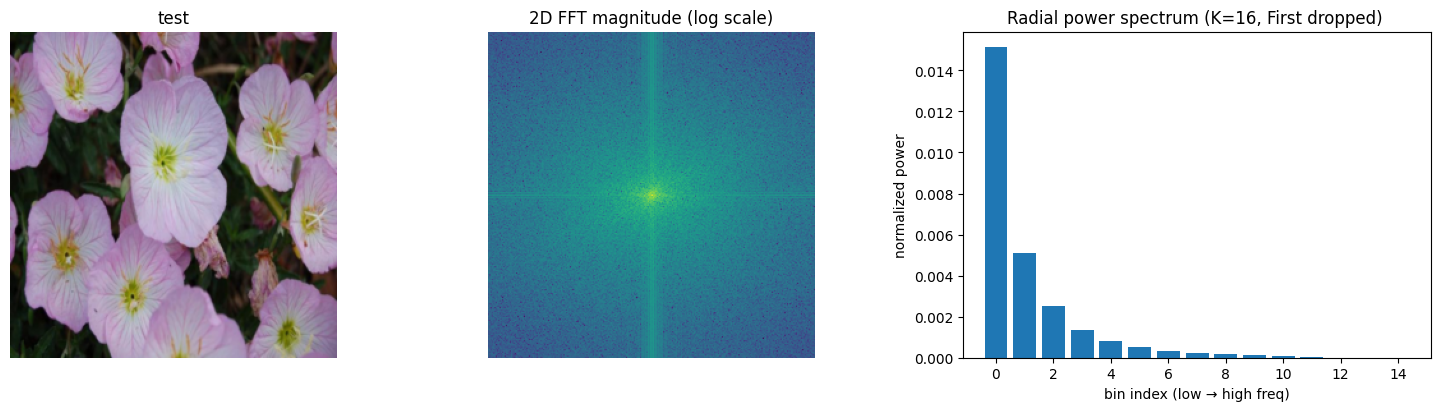

In [1]:
import numpy as np
import torchvision
import matplotlib.pyplot as plt

fs = 256  # Hz
T = 1.0  # seconds
N = int(fs * T)
t = np.arange(N) / fs

train = torchvision.datasets.Flowers102(root='./data', split="train", download=True, transform=None)
sample_img, _ = train[0]

rng = np.random.default_rng(42)
sig = 0.8 * np.sin(2 * np.pi * 5 * t) + 0.4 * np.sin(2 * np.pi * 20 * t) + 0.1 * rng.standard_normal(N)

spec = np.fft.rfft(sig)
freqs = np.fft.rfftfreq(N, d=1 / fs)
mag = np.abs(spec)

H = W = 256
y, x = np.mgrid[:H, :W]
theta = np.deg2rad(30.0)
cycles = 8
kx = (cycles / W) * np.cos(theta)
ky = (cycles / W) * np.sin(theta)
img = 0.5 * (1 + np.cos(2 * np.pi * (kx * x + ky * y)))
img += 0.25 * (1 + np.cos(2 * np.pi * (2 * kx * x + 2 * ky * y)))

F = np.fft.fft2(img)
Fshift = np.fft.fftshift(F)
mag2 = np.abs(Fshift)

K = 16
u = np.fft.fftshift(np.fft.fftfreq(W))
v = np.fft.fftshift(np.fft.fftfreq(H))
U, V = np.meshgrid(u, v)
R = np.sqrt(U ** 2 + V ** 2)
r = R.ravel()
power = (np.abs(Fshift) ** 2).ravel()

r_max = 0.5 * np.sqrt(2)  # Nyquist radius to corner in 2D
edges = np.linspace(0.0, r_max, K + 1)
bin_idx = np.digitize(r, edges) - 1
bin_idx = np.clip(bin_idx, 0, K - 1)

binned_power = np.bincount(bin_idx, weights=power, minlength=K).astype(float)
binned_power /= binned_power.sum() + 1e-12

# Row 1: 1D signal and its spectrum
_, axes1 = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)

axes1[0].plot(t, sig)
axes1[0].set_title("1D signal (time domain)")
axes1[0].set_xlabel("time [s]")
axes1[0].set_ylabel("amplitude")

axes1[1].plot(freqs, mag)
axes1[1].set_title("1D magnitude spectrum (rFFT)")
axes1[1].set_xlabel("frequency [Hz]")
axes1[1].set_ylabel("|X(f)|")

plt.show()

# Row 2: 2D image, FFT magnitude (log), and radial spectrum
_, axes2 = plt.subplots(1, 3, figsize=(15, 4), constrained_layout=True)

axes2[0].imshow(img, cmap="gray")
axes2[0].set_title("Synthetic image (oriented gratings)")
axes2[0].axis("off")

axes2[1].imshow(np.log1p(mag2), cmap="gray")
axes2[1].set_title("2D FFT magnitude (log scale)")
axes2[1].axis("off")

axes2[2].bar(np.arange(K), binned_power)
axes2[2].set_title("Radial power spectrum (K=16)")
axes2[2].set_xlabel("bin index (low → high freq)")
axes2[2].set_ylabel("normalized power")

plt.show()

# Row 3: FFT from a sample image
_, axes3 = plt.subplots(1, 3, figsize=(15, 4), constrained_layout=True)

resize = torchvision.transforms.Resize((H, W),
                                       interpolation=torchvision.transforms.InterpolationMode.BILINEAR)
sample_img = resize(sample_img)

F = np.fft.fft2(sample_img.convert("L"))
Fshift = np.fft.fftshift(F)
sample_mag = np.abs(Fshift)

sample_power = (sample_mag ** 2).ravel()

sample_binned_power = np.bincount(bin_idx, weights=sample_power, minlength=K).astype(float)
sample_binned_power /= sample_binned_power.sum() + 1e-12

axes3[0].axis('off')
axes3[0].set_title('test')
axes3[0].imshow(sample_img)

axes3[1].axis('off')
axes3[1].imshow(np.log1p(sample_mag))
axes3[1].set_title("2D FFT magnitude (log scale)")

axes3[2].bar(np.arange(K-1), sample_binned_power[1:])
axes3[2].set_title("Radial power spectrum (K=16, First dropped) ")
axes3[2].set_xlabel("bin index (low → high freq)")
axes3[2].set_ylabel("normalized power")

plt.show()


## References
1. Samyadeep Basu, Shell Hu, Daniela Massiceti, and Soheil Feizi. *Strong baselines for parameter-efficient
few-shot fine-tuning.* In AAAI, 2024.
2. Kaiyang Zhou, Jingkang Yang, Chen Change Loy, and Ziwei Liu. *Learning to prompt for vision-language
models.* IJCV, 2022.
3. Cooley, J. W., & Tukey, J. W. (1965). *An algorithm for the machine calculation of complex Fourier series.*


## 4.Project Code
Below, you can find the project code including classes and training / evaluation loops.

In [2]:
## This install CLIP python module (Google Colab already has all other dependencies)
!pip install git+https://github.com/openai/CLIP.git

%matplotlib inline
%config InlineBackend.figure_format = "retina"

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-z591qlj5
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-z591qlj5
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


In [3]:
import clip
import time
import torch
import os, random
import torchvision
import pandas as pd

from tqdm import tqdm

from typing import Dict

from torch.utils.tensorboard import SummaryWriter

LR = 1e-3
WEIGHT_DECAY = 1e-4

DEFAULT_TRAINING_EPOCHS = 5

RN50_CLIP_MODEL = 'RN50'
VIT16_CLIP_MODEL = 'ViT-B/16'
VIT32_CLIP_MODEL = 'ViT-B/32'

# BATCH settings hits:
# - 4GB  of VRAM -> batch = 3   (My laptop needs a better GPU :( )
# - 15GB of VRAM -> batch = 16  (Google Colab T4 $)
# - 30GB of VRAM -> batch = 32  (Google Colab L4 $$)
# - 40GB of VRAM -> batch = 48  (Google Colab A100 $$$)

BATCH_SIZE = 3
NUM_WORKERS = max(1, int(os.cpu_count() / 4))

os.makedirs('../models/data', exist_ok=True)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

CLASS_NAMES = ["pink primrose", "hard-leaved pocket orchid", "canterbury bells", "sweet pea", "english marigold",
               "tiger lily", "moon orchid", "bird of paradise", "monkshood", "globe thistle", "snapdragon",
               "colt's foot", "king protea", "spear thistle", "yellow iris", "globe-flower", "purple coneflower",
               "peruvian lily", "balloon flower", "giant white arum lily", "fire lily", "pincushion flower",
               "fritillary", "red ginger", "grape hyacinth", "corn poppy", "prince of wales feathers",
               "stemless gentian", "artichoke", "sweet william", "carnation", "garden phlox", "love in the mist",
               "mexican aster", "alpine sea holly", "ruby-lipped cattleya", "cape flower", "great masterwort",
               "siam tulip", "lenten rose", "barbeton daisy", "daffodil", "sword lily", "poinsettia",
               "bolero deep blue", "wallflower", "marigold", "buttercup", "oxeye daisy", "common dandelion", "petunia",
               "wild pansy", "primula", "sunflower", "pelargonium", "bishop of llandaff", "gaura", "geranium",
               "orange dahlia", "pink-yellow dahlia?", "cautleya spicata", "japanese anemone", "black-eyed susan",
               "silverbush", "californian poppy", "osteospermum", "spring crocus", "bearded iris", "windflower",
               "tree poppy", "gazania", "azalea", "water lily", "rose", "thorn apple", "morning glory",
               "passion flower", "lotus", "toad lily", "anthurium", "frangipani", "clematis", "hibiscus", "columbine",
               "desert-rose", "tree mallow", "magnolia", "cyclamen", "watercress", "canna lily", "hippeastrum",
               "bee balm", "ball moss", "foxglove", "bougainvillea", "camellia", "mallow", "mexican petunia",
               "bromelia", "blanket flower", "trumpet creeper", "blackberry lily"]


In [4]:
def log_values(writer, step, loss, accuracy, prefix):
    writer.add_scalar(f"{prefix}/loss", loss, step)
    writer.add_scalar(f"{prefix}/accuracy", accuracy, step)


def harmonic_mean(a, b):
    # Adding very small quantity (0,[11]01) to avoid 0 division
    return 2 * a * b / (a + b + 1e-12)


def print_device_info(device):
    print(f'Device found: {device.upper()}')
    if device == 'cuda':
        memory = torch.cuda.get_device_properties(0).total_memory
        device_name = torch.cuda.get_device_name(torch.cuda.current_device())
        print(f'CUDA available memory: {memory / 1024 ** 3:.1f}GB on {device_name}')


def seed_everything(seed: int = 42):
    """
    Setups the seed used by all random function in the project
    :param seed:   the seed to set
    """

    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    np.random.RandomState(seed)

    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [5]:
def display_evaluation_results(data_results):
    '''
        results = {
            "RN50": {
                "ZeroShot": {"base": ..., "novel": ..., "hm": ...},
                "FewShot":  {"base": ..., "novel": ..., "hm": ...},
            },
            "ViT-B/16": {
                "ZeroShot": {"base": ..., "novel": ..., "hm": ...},
                "FewShot":  {"base": ..., "novel": ..., "hm": ...},
            }
        }
    '''

    results = pd.DataFrame(data_results)

    def to_pct(v):
        # accept floats or arrays
        v = np.array(v, dtype=float)
        if np.nanmax(v) <= 1.0:
            v *= 100.0
        return v

    models = list(results.keys())
    methods = ["ZeroShot", "FewShot"]
    metrics = ["base", "novel", "hm"]

    fig, axes = plt.subplots(1, len(models), figsize=(12, 5), sharey=True)
    if len(models) == 1:
        axes = [axes]

    for ax, model in zip(axes, models):
        # data matrix: rows=methods, cols=metrics
        mat = np.array([[results[model][m][k] for k in metrics] for m in methods], dtype=float)
        mat = to_pct(mat)

        x = np.arange(len(methods))  # ZeroShot, FewShot
        width = 0.25

        # group bars for metrics
        for j, metric in enumerate(metrics):
            ax.bar(x + (j - 1) * width, mat[:, j], width, label=metric.capitalize())

        ax.set_title(model)
        ax.set_xticks(x)
        ax.set_xticklabels(["Zero-shot", "Few-shot"])
        ax.set_ylabel("Accuracy (%)")
        ax.set_ylim(0, 100)
        # add labels on bars
        for container in ax.containers:
            ax.bar_label(container, fmt="%.1f", padding=3)

    # make a single legend for all subplots
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper center", ncol=len(metrics), frameon=False)
    plt.tight_layout()
    plt.show()

In [6]:
# The following are methods defined to create the training/evaluation dataset
# They perform data batching and split train/test/validation sets as well as basic/novel datasets
def get_data(data_dir="./data", transform=None):
    print('Loading Flowers102 dataset')

    # This torchvision utility method is using predefined train/val/test splitting
    train = torchvision.datasets.Flowers102(root=data_dir, split="train", download=True, transform=transform)
    val = torchvision.datasets.Flowers102(root=data_dir, split="val", download=True, transform=transform)
    test = torchvision.datasets.Flowers102(root=data_dir, split="test", download=True, transform=transform)
    return train, val, test


def base_novel_categories(dataset):
    # set returns the unique set of all dataset classes
    all_classes = set(dataset._labels)
    # and let's count them
    num_classes = len(all_classes)

    # here list(range(num_classes)) returns a list from 0 to num_classes - 1
    # then we slice the list in half and generate base and novel category lists
    base = list(range(num_classes))[:num_classes // 2]
    novel = list(range(num_classes))[num_classes // 2:]
    return base, novel


def split_data(dataset, base_classes):
    # these two lists will store the sample indexes
    base_categories_samples = []
    novel_categories_samples = []

    # we create a set of base classes to compute the test below in O(1)
    # this is optional and can be removed
    base_set = set(base_classes)

    for sample_id, label in enumerate(dataset._labels):
        # If the sample doesn't belong to base classes it belongs to novel ones
        if label in base_set:
            base_categories_samples.append(sample_id)
        else:
            novel_categories_samples.append(sample_id)

    base_dataset = torch.utils.data.Subset(dataset, base_categories_samples)
    novel_dataset = torch.utils.data.Subset(dataset, novel_categories_samples)
    return base_dataset, novel_dataset

In [7]:
# The following is the code to perform the baseline zero-shot evaluation

@torch.no_grad()  # Disables gradients calculation for performance improvements
def eval_zero_shot(model, dataset, categories, batch_size, device, label=""):
    # CLIP is set to evaluation model (frozen weights)
    model.eval()

    # Remap labels into a contiguous set starting from zero
    contig_cat2idx = {cat: idx for idx, cat in enumerate(categories)}

    # We need to build the prompts to feed CLIP text encoder
    text_inputs = clip.tokenize(
        [f"a photo of a {CLASS_NAMES[c]}, a type of flower." for c in categories]
    ).to(device)

    # Text features are encoded and cached once as they are image agnostic
    text_features = model.encode_text(text_inputs)
    text_features = torch.nn.functional.normalize(text_features, dim=-1)

    dataloader = torch.utils.data.DataLoader(dataset,
                                             batch_size=batch_size,
                                             shuffle=False,
                                             num_workers=2)

    correct_predictions = 0
    for image, target in tqdm(dataloader, desc=label):
        # base categories range from 0 to 50, while novel ones from 51 to 101
        # therefore we must map categories to the [0, 50], otherwise we will have wrong predictions
        # Map targets in contiguous set starting from zero
        # Labels needs to be .long() in pytorch
        target = torch.Tensor([contig_cat2idx[t.item()] for t in target]).long()

        image = image.to(device)
        target = target.to(device)

        # forward image through CLIP image encoder
        image_features = model.encode_image(image)
        image_features = torch.nn.functional.normalize(image_features, dim=-1)

        # here cosine similarity between image and text features and keep the argmax for every row (every image)
        predicted_class = (image_features @ text_features.T).argmax(dim=-1)
        # now we check which are correct, and sum them (False == 0, True == 1)
        correct_predictions += (predicted_class == target).sum().item()

    # and now we compute the accuracy
    accuracy = correct_predictions / len(dataset)
    return accuracy

In [8]:
# The following are the classes that will implement the FFT-CoCoOP

# FFTTokenProjector is responsible for
class FFTTokenProjector(torch.nn.Module):
    def __init__(self, ctx_dim, device, n_ctx=8, bins=16, drop_first_bin=False, images_shape=(224, 224)):
        super().__init__()
        self.device = device

        self.drop_first_bin = drop_first_bin
        self.bins: int = bins

        self.n_ctx = n_ctx
        self.ctx_dim: int = ctx_dim

        # This is the MLP responsible for radial FFT projection to text tokens
        # The input layer has a size of bins * 3 (number of color channels)
        # If the first bin is dropped, the shape of the project must have 1 bin less
        proj_bins = bins - 1 if drop_first_bin else bins
        self.proj = torch.nn.Sequential(
            # Flattening is important to remove the color dimension and create a single input for the MLP
            torch.nn.Flatten(start_dim=1),
            torch.nn.Linear(proj_bins * 3, proj_bins),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(proj_bins, n_ctx * ctx_dim),
        ).to(device)

        # Generic FFT components initialization (they must be calculated only once)
        height, width = images_shape
        cy, cx = (height - 1) / 2, (width - 1) / 2

        yy, xx = torch.meshgrid(torch.arange(height), torch.arange(width), indexing='ij')

        radius = torch.sqrt((xx - cx) ** 2 + (yy - cy) ** 2)
        self.radius_norm = radius / radius.max()

        # edges: bins+1 values
        self.edges = torch.linspace(0.0,
                                    self.radius_norm.max(),
                                    steps=self.bins + 1,
                                    device=self.radius_norm.device)

    def get_trainable_parameters(self):
        return [
            {'params': list(self.proj.parameters()), 'weight_decay': 1e-4},
        ]

    def get_savable_parameters(self):
        return {
            name: param.detach().cpu()
            for name, param in self.proj.named_parameters()
        }

    def set_saved_parameters(self, saved_parameters):
        for name, param in self.proj.named_parameters():
            if name in saved_parameters:
                param.data = saved_parameters[name].to(self.device)

    def forward(self, image_tensor):
        batch = image_tensor.size(0)

        # The third result is the fft_magnitude. To show it using plt and have better understanding, you must apply
        # Output shape: [batch, color_channels, bins]
        fft_descriptors, _, __ = self.__radial_fourier_descriptors(image_tensor)

        # Output shape: [batch, n_ctx * ctx_dim] (the output of the MLP)
        token = self.proj(fft_descriptors)

        # The view operation changes the shape of the tensor to de-flat it
        # Output shape: [batch, n_ctx, ctx_dim]
        token = token.view(batch, self.n_ctx, self.ctx_dim)
        token = torch.nn.functional.normalize(token, dim=-1)

        return token

    @torch.no_grad()
    def __radial_fourier_descriptors(self, image_tensor):
        ## We need to make sure to work in gray mode
        batch, color_channels, height, width = image_tensor.shape

        # The 0-frequencies are normally in the top right corner
        # By shifting we move these components to the center.
        fft_image = torch.fft.fft2(image_tensor, dim=(-2, -1), norm='ortho')
        fft_magnitude = torch.abs(fft_image)

        # assign each pixel to a bin index in [0, bins-1]
        bin_ids = torch.bucketize(self.radius_norm, self.edges) - 1
        bin_ids = bin_ids.clamp(min=0, max=self.bins - 1)
        bin_ids = (bin_ids
                   .unsqueeze(0)
                   .unsqueeze(1)
                   .expand(batch, color_channels, -1, -1)
                   .to(self.device))

        bin_ids_flat = bin_ids.reshape(batch, color_channels, -1)  # (B, C, H*W)
        mag_flat = fft_magnitude.squeeze(1).reshape(batch, color_channels, -1)  # (B, C, H*W)

        sums = torch.zeros(batch,
                           color_channels,
                           self.bins,
                           device=image_tensor.device,
                           dtype=image_tensor.dtype).scatter_add_(dim=2, index=bin_ids_flat, src=mag_flat)
        ones = torch.ones_like(bin_ids_flat, dtype=image_tensor.dtype)
        counts = torch.zeros(batch, color_channels, self.bins, device=image_tensor.device) \
            .scatter_add_(2, bin_ids_flat, ones)

        descriptors = sums / (counts + 1e-8)
        if self.drop_first_bin:
            descriptors = descriptors[:, :, 1:]

        descriptors /= descriptors.sum(dim=1, keepdim=True) + 1e-12

        return descriptors, edges, fft_magnitude


# This class is responsible for text preprocessing and encoding using CLIP transformer
class TextEncoder(torch.nn.Module):

    def __init__(self, clip_model, eot_indices_per_class: Dict):
        super().__init__()
        self.clip_model = clip_model
        self.transformer = clip_model.transformer

        self.current_class_type = 'base'

        self.positional_embedding = clip_model.positional_embedding
        self.ln_final = clip_model.ln_final
        self.text_projection = clip_model.text_projection
        self.token_embedding = clip_model.token_embedding

        '''
            eot_indices_per_class: dict {'base'|'novel' -> LongTensor [C]}
                For each class index in this forward, tells where its End-Of-Text (EOT)
                token sits inside the T-length sequence. This let pick the correct
                token embedding as CLIP’s text feature for that class.
        '''
        self.eot_indices_per_class = eot_indices_per_class

    # This method allows the usage of the correct classes to prompt creation
    def set_class_type(self, class_type):
        assert class_type in ['base', 'novel']
        self.current_class_type = class_type

    def forward(self, prompts):
        batch_size, num_classes, tokens_count, tokens_size = prompts.shape
        dtype = next(self.transformer.parameters()).dtype

        # Output shape [batch, classes]
        eot_idx = self.eot_indices_per_class[self.current_class_type] \
            .unsqueeze(0) \
            .expand(batch_size, -1).reshape(-1)

        to_encode = prompts + self.clip_model.positional_embedding[:prompts.size(2), :].unsqueeze(0)
        to_encode = to_encode.to(dtype=dtype, device=prompts.device)

        to_encode = to_encode.reshape(batch_size * num_classes, tokens_count, tokens_size)

        # CLIP transformer expect a tensor of shape [tokens, batch, ctx_dim]. Need a dimensional switch
        to_encode = to_encode.permute(1, 0, 2)

        # Applying CLIP text transformation
        to_encode = self.transformer(to_encode)

        # Need to switch dimensions back to [batch, tokens, ctx_dim]
        to_encode = to_encode.permute(1, 0, 2)
        to_encode = self.ln_final(to_encode)

        to_encode = to_encode[torch.arange(to_encode.shape[0]), eot_idx] @ self.text_projection
        return to_encode


## This class is responsible for preparing the final prompt to be fed to CLIP text encoder
class PromptLearnerWithFFT(torch.nn.Module):

    def __init__(self,
                 clip_model,
                 class_data,
                 n_ctx=4,
                 bins=16,
                 drop_first_bin=False,
                 images_shape=(224, 224)):
        super().__init__()

        self.clip_model = clip_model
        self.device = next(clip_model.parameters()).device

        self.class_data: Dict = class_data
        self.current_class_type = 'base'

        self.n_ctx: int = n_ctx # -> int will make PyCharm happy :)
        self.ctx_dim: int = clip_model.ln_final.weight.shape[0]

        ## CLIP allows only self.ctx_dim (77) tokens. More tokes will be discarded
        ## ColorChannels = 3
        assert (n_ctx * 2) + 1 <= 77

        self.__prepare_class_embeddings()
        self.fft_projector = FFTTokenProjector(bins=bins,
                                               n_ctx=n_ctx,
                                               device=self.device,
                                               ctx_dim=self.ctx_dim,
                                               images_shape=images_shape,
                                               drop_first_bin=drop_first_bin)

        # A set of trainable parameters to be added together with the FFT transformation
        self.ctx = torch.nn.Parameter(torch.randn(n_ctx, self.ctx_dim) * 0.02)

        # The trainable parameter to weight FFT prompts vs Contextual prompts
        self.fft_weight = torch.nn.Parameter(torch.randn(1) * 0.02)

        eot_idx = {
            'base': self.base_eot_idx_per_class,
            'novel': self.novel_eot_idx_per_class
        }

        self.text_encoder = TextEncoder(self.clip_model,
                                        eot_indices_per_class=eot_idx)

    def get_trainable_parameters(self):
        return [
            {"params": [self.ctx, self.fft_weight], "weight_decay": 0.0},
            *self.fft_projector.get_trainable_parameters()
        ]

    def get_savable_parameters(self):
        return {
            'ctx': self.ctx.detach().cpu(),
            'fft_weight': self.fft_weight.detach().cpu(),
            'fft_projector': self.fft_projector.get_savable_parameters()
        }

    def set_saved_parameters(self, saved_parameters):
        self.ctx.data = saved_parameters['ctx'].to(self.device)
        self.fft_weight.data = saved_parameters['fft_weight'].to(self.device)

        self.fft_projector.set_saved_parameters(saved_parameters['fft_projector'])


    @staticmethod
    def __build_class_prompts(class_names, n_ctx):
        fixed_class_names = [name.replace('_', '') for name in class_names]
        placeholders = ' '.join(['X'] * n_ctx * 2)
        return [f'{placeholders} {name}' for name in fixed_class_names]

    @torch.no_grad()
    def __prepare_class_embeddings(self):
        self.prefix_idx = 1  ## We must not overwrite the BOS token

        # The EOT token ID, defined by CLIP model
        self.eot_token_id = 49407

        for key, data in self.class_data.items():
            class_prompts = self.__build_class_prompts(data['classes'], self.n_ctx)

            tokenized_prompts = clip.tokenize(class_prompts).to(self.device)
            embeddings = self.clip_model.token_embedding(tokenized_prompts)

            self.register_buffer(f'{key}_class_prompts', embeddings)
            self.register_buffer(
                f'{key}_eot_idx_per_class',
                (tokenized_prompts == 49407).int().argmax(dim=1)  # [C]
            )

    def set_class_type(self, class_type):
        assert class_type in ['base', 'novel']
        self.current_class_type = class_type
        self.text_encoder.set_class_type(class_type)

    def forward(self, images_tensor):
        batch_size = images_tensor.size(0)

        class_data = self.class_data[self.current_class_type]
        num_classes = class_data['n_classes']

        batch_embeddings = getattr(self, f'{self.current_class_type}_class_prompts').to(self.device)

        batch_embeddings = batch_embeddings.unsqueeze(0).expand(batch_size, -1, -1, -1).clone()

        ## Unsqueeze 0 -> 1 because we need to add the batch and classes dimension
        ctx = self.ctx\
            .view(self.n_ctx, self.ctx_dim) \
            .unsqueeze(0) \
            .unsqueeze(1) \
            .expand(batch_size, num_classes, -1, -1)

        fft_ctx = self.fft_projector(images_tensor)

        # Unsqueeze 1 because fft_ctx already has the batch dimension
        fft_ctx = fft_ctx.unsqueeze(1) \
            .expand(-1, num_classes, -1, -1)

        # This parameter is processed with sigmoid to keep it in the range [0, 1]
        fft_learned_weight = torch.sigmoid(self.fft_weight)
        fft_learned_weight = fft_learned_weight \
            .unsqueeze(1) \
            .unsqueeze(1) \
            .expand(batch_size, num_classes, self.n_ctx, -1)

        joint_ctx = torch.cat([
            (1.0 - fft_learned_weight) * fft_ctx,
            fft_learned_weight * ctx
        ], dim=2)

        end_ctx_idx = self.prefix_idx + self.n_ctx * 2
        batch_embeddings[:, :, self.prefix_idx:end_ctx_idx, :] = joint_ctx

        text_features = self.text_encoder(batch_embeddings)
        return text_features


class FFTCoCoOpCLIP(torch.nn.Module):
    def __init__(self,
                 clip_model,
                 base_class,
                 novel_class,
                 fft_bins=16,
                 drop_first_bin=False,
                 images_shape=(224, 224)):
        super().__init__()

        self.current_class_type = 'base'

        ## Adding the Dict type will make PyCharm happy :)
        self.class_data: Dict = {
            'base': {
                'classes': base_class,
                'n_classes': len(base_class),
            },
            'novel': {
                'classes': novel_class,
                'n_classes': len(novel_class),
            }
        }

        self.clip_model = clip_model
        self.__freeze_clip_model()

        self.device = next(clip_model.parameters()).device
        self.clip_text_width = self.clip_model.text_projection.shape[1]

        self.fft_prompt_learner = PromptLearnerWithFFT(bins=fft_bins,
                                                       clip_model=self.clip_model,
                                                       class_data=self.class_data,
                                                       images_shape=images_shape,
                                                       drop_first_bin=drop_first_bin)

    def __freeze_clip_model(self):
        self.clip_model.eval()
        ## We need to be sure that CLIP parameters are frozen by disabling the gradient update
        for clip_param in self.clip_model.parameters():
            clip_param.requires_grad = False

    def get_trainable_parameters(self):
        return self.fft_prompt_learner.get_trainable_parameters()

    def get_savable_parameters(self):
        return self.fft_prompt_learner.get_savable_parameters()

    def set_saved_parameters(self, saved_parameters):
        self.fft_prompt_learner.set_saved_parameters(saved_parameters)


    def set_class_type(self, class_type):
        assert class_type in ['base', 'novel']
        self.fft_prompt_learner.set_class_type(class_type)

    def forward(self, image_tensor):
        batch_size = image_tensor.size(0)
        class_data = self.class_data[self.current_class_type]

        image_embeddings = self.__encode_image(image_tensor)

        text_features = self.fft_prompt_learner(image_tensor)

        image_features = torch.nn.functional.normalize(image_embeddings, dim=-1)
        text_features = torch.nn.functional.normalize(text_features, dim=-1)

        text_features = text_features.view(batch_size, class_data['n_classes'], -1)

        # In this step, the shape of image feature is [batch, ctx_dim].
        # To allow the matrix multiplication (needed for cosine similarity) we need to expand it to a
        # shape of [batch, num_classes, ctx_size] to make it compliant to text_features
        logit_scale = self.clip_model.logit_scale.exp()
        logits = logit_scale * image_features @ text_features.transpose(1, 2)  # Cosine similarity

        # This product has been done between
        # image_features -> [batch, ctx_dim]
        # text_features  -> [batch, classes, ctx_dim]
        # I don't care about the batch dimension since products should be done per each batch element so should
        #   only transpose dimensions 1,2 (classes, ctx_dim) of text_features
        # The result would be a tensor of shape [batch, batch, classes] that can be shrunk to [batch, classes]
        #   without loosing information

        # torch.arange is a method that selects the first x-1 elements (in this case batch-1)
        # By doing this also on the second axis I'm selecting the diagonal between the first two dimensions (which are
        #   exactly the same) thus reducing the shape to [batch, classes]
        return logits[torch.arange(batch_size), torch.arange(batch_size), :]

    @torch.no_grad()
    def __encode_image(self, image_tensor):
        encoded_image = self.clip_model.encode_image(image_tensor)
        return torch.nn.functional.normalize(encoded_image, dim=-1)

In [9]:
def train_epoch(nn_model, dataset_loader, optimizer, label=''):
    nn_model.set_class_type('base')

    total, correct, loss_sum = 0, 0, .0
    for image, clazz in tqdm(dataset_loader, desc=f'\t{label}'):
        image = image.to(nn_model.device)
        clazz = clazz.to(nn_model.device)

        sims = nn_model(image)

        # Default parameter for reduction is mean which average the losses for all the elements in the batch
        # To have the true epoch loss I should restore it by multiplying it by the batch size and then
        # average these sums with the total number of elements
        # By using sum parameter we can directly avoid the multiplication because
        # cross_entropy(sims, clazz, reduction='sum') = cross_entropy(sims, clazz) * batch_size
        loss = torch.nn.functional.cross_entropy(sims, clazz, reduction='sum')

        # This operation resets the previous calculated gradients
        optimizer.zero_grad()

        # This travels back to all the chained gradients to get the final one
        loss.backward()

        # Performs the optimization only for the parameters assigned to it (CLIP ones are frozen)
        optimizer.step()

        loss_sum += loss.item()

        prediction = sims.argmax(1)

        total += image.size(0)
        correct += (prediction == clazz).sum().item()

    return loss_sum / total, correct / total

In [10]:
@torch.no_grad()
def evaluate(nn_model,
             dataset_loader,
             label=None,
             is_novel=False,
             is_validation=True,
             base_classes_count=None):
    if is_novel and not base_classes_count:
        raise Exception('During novel evaluation you must provide base_classes_count')

    nn_model.eval()
    nn_model.set_class_type('novel' if is_novel else 'base')

    if not label:
        label = 'Novel Evaluation' if is_novel else 'Base Evaluation'

    y_true = []
    y_pred = []

    total, correct, loss_sum = 0, 0, .0
    for image, clazz in tqdm(dataset_loader, desc=f'\t{label}'):
        image = image.to(nn_model.device)
        clazz = clazz.to(nn_model.device)

        sims = nn_model(image)

        classes_for_loss = clazz - base_classes_count if is_novel else clazz
        loss_sum += torch.nn.functional.cross_entropy(sims, classes_for_loss, reduction='sum').item()

        prediction = sims.argmax(1)
        if is_novel:
            prediction = prediction + base_classes_count

        total += image.size(0)
        correct += (prediction == clazz).sum().item()

        if not is_validation:
            ## We need to detach these tensors to avoid GPU memory leaks
            y_true.append(clazz.detach().cpu())
            y_pred.append(prediction.detach().cpu())

    if is_validation:
        predictions = None
    else:
        predictions = {
            'true': torch.cat(y_true, dim=0),
            'pred': torch.cat(y_pred, dim=0),
        }

    return correct / total, loss_sum, predictions

In [11]:
def start_few_shot_evaluation(model_name, epochs=DEFAULT_TRAINING_EPOCHS, train_batch=BATCH_SIZE,
                              test_batch=BATCH_SIZE):
    print(f'Loading CLIP Model: {model_name} using {DEVICE.upper()}')
    model, preprocess = clip.load(model_name, device=DEVICE)
    model.eval()

    writer = SummaryWriter(log_dir=f"runs/{model_name}")

    # We need to create datasets per each model to use their preprocess pipelines
    train_set, val_set, test_set = get_data(transform=preprocess)

    # split classes into base and novel
    base_classes, novel_classes = base_novel_categories(train_set)

    base_class_names = [CLASS_NAMES[index] for index in base_classes]
    novel_class_names = [CLASS_NAMES[index] for index in novel_classes]

    print("Base Class Names:", base_class_names)
    print("Novel Class Names:", novel_class_names)

    # split the three datasets
    train_base, _ = split_data(train_set, base_classes)
    val_base, _ = split_data(val_set, base_classes)
    test_base, test_novel = split_data(test_set, base_classes)

    val_loader = torch.utils.data.DataLoader(val_base,
                                             batch_size=test_batch,
                                             num_workers=NUM_WORKERS,
                                             shuffle=False)
    test_loader = torch.utils.data.DataLoader(test_base,
                                              batch_size=test_batch,
                                              num_workers=NUM_WORKERS,
                                              shuffle=False)
    train_loader = torch.utils.data.DataLoader(train_base,
                                               batch_size=train_batch,
                                               num_workers=NUM_WORKERS,
                                               shuffle=True)

    test_novel_loader = torch.utils.data.DataLoader(test_novel,
                                                    batch_size=test_batch,
                                                    num_workers=NUM_WORKERS,
                                                    shuffle=False)

    print()

    zero_base_accuracy = eval_zero_shot(model=model,
                                        dataset=test_base,
                                        categories=base_classes,
                                        batch_size=128,
                                        device=DEVICE,
                                        label="🧠 Zero-shot evaluation on Base Classes")
    zero_novel_accuracy = eval_zero_shot(model=model,
                                         dataset=test_novel,
                                         categories=novel_classes,
                                         batch_size=128,
                                         device=DEVICE,
                                         label="🧠 Zero-shot evaluation on Novel Classes")

    _, img_h, img_w = train_set[0][0].shape
    fft_model = FFTCoCoOpCLIP(clip_model=model,
                              drop_first_bin=True,
                              images_shape=(img_h, img_w),
                              base_class=base_class_names,
                              novel_class=novel_class_names).to(DEVICE)

    print()
    print(f'Starting FewShot training with {model_name}')

    best_acc = 0
    model_path = f'models/{model_name.replace("/", "_")}.pth'

    # Only train parameters created for this project
    # - ctx
    # - fft_weight
    # - fft_projector MLP parameters

    no_improvements = 0
    optimizer = torch.optim.AdamW(fft_model.get_trainable_parameters(), lr=LR)
    for epoch in range(epochs):
        t0 = time.time()

        tr_loss, tr_acc = train_epoch(fft_model, train_loader, optimizer, label='FewShot Training')
        val_acc, val_loss, _ = evaluate(fft_model, val_loader, label='FewShot Validation')

        if val_acc > best_acc:
            no_improvements = 0
            best_acc = val_acc

            torch.save(fft_model.get_savable_parameters(), model_path)
            print(f"\tSaved best FFT model to {model_path} (val_acc={best_acc:.4f})")
        else:
            no_improvements += 1

        if no_improvements > 1:
            print(f'Stopping training of {model_name} using the EarlyStopping strategy')

        dt = time.time() - t0

        print(f"\tEpoch {epoch + 1:02d} | loss {tr_loss:.4f} | train {tr_acc:.3f} | val {val_acc:.3f} | {dt:.1f}s")
        print()

        log_values(writer, epoch + 1, tr_loss, tr_acc, 'Training')
        log_values(writer, epoch + 1, val_loss, val_acc, 'Validation')

    fft_params = torch.load(model_path, map_location=DEVICE)
    fft_model.set_saved_parameters(fft_params)


    fft_test_acc, _, base_preds = evaluate(fft_model, test_loader, is_validation=False)

    fft_test_novel_acc, _, novel_preds = evaluate(fft_model,
                                                  test_novel_loader,
                                                  is_novel=True,
                                                  is_validation=False,
                                                  base_classes_count=len(base_class_names))

    zero_shot_data = {
        'base': zero_base_accuracy * 100,
        'novel': zero_novel_accuracy * 100,
        'hm': harmonic_mean(zero_base_accuracy, zero_novel_accuracy) * 100
    }

    few_shot_data = {
        'base': fft_test_acc * 100,
        'novel': fft_test_novel_acc * 100,
        'hm': harmonic_mean(fft_test_acc, fft_test_novel_acc) * 100
    }

    # Removing models for resources clean up
    del model, fft_model
    return zero_shot_data, few_shot_data, base_preds, novel_preds

In [12]:
def main():
    #zero_shot_data_32, few_shot_data_32, _, __ = start_few_shot_evaluation(VIT32_CLIP_MODEL, test_batch=32)
    #rn_zero_shot_data, rn_few_shot_data, _, __ = start_few_shot_evaluation(RN50_CLIP_MODEL, test_batch=32)
    zero_shot_data, few_shot_data, base_pred_16, novel_pred_16 = start_few_shot_evaluation(VIT16_CLIP_MODEL,
                                                                                           test_batch=32)

    '''
    'RN50': {
        'ZeroShot': rn_zero_shot_data,
        'FewShot': rn_few_shot_data
    },
    'ViT-B/32': {
        'ZeroShot': zero_shot_data_32,
        'FewShot': few_shot_data_32
    }
    '''
    chart_data = {
        'ViT-B/16': {
            'ZeroShot': zero_shot_data,
            'FewShot': few_shot_data
        },
    }

    return chart_data, base_pred_16, novel_pred_16


print_device_info(device=DEVICE)
seed_everything(42)

Device found: CUDA
CUDA available memory: 3.7GB on NVIDIA RTX 500 Ada Generation Laptop GPU


Loading CLIP Model: ViT-B/16 using CUDA
Loading Flowers102 dataset
Base Class Names: ['pink primrose', 'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea', 'english marigold', 'tiger lily', 'moon orchid', 'bird of paradise', 'monkshood', 'globe thistle', 'snapdragon', "colt's foot", 'king protea', 'spear thistle', 'yellow iris', 'globe-flower', 'purple coneflower', 'peruvian lily', 'balloon flower', 'giant white arum lily', 'fire lily', 'pincushion flower', 'fritillary', 'red ginger', 'grape hyacinth', 'corn poppy', 'prince of wales feathers', 'stemless gentian', 'artichoke', 'sweet william', 'carnation', 'garden phlox', 'love in the mist', 'mexican aster', 'alpine sea holly', 'ruby-lipped cattleya', 'cape flower', 'great masterwort', 'siam tulip', 'lenten rose', 'barbeton daisy', 'daffodil', 'sword lily', 'poinsettia', 'bolero deep blue', 'wallflower', 'marigold', 'buttercup', 'oxeye daisy', 'common dandelion', 'petunia']
Novel Class Names: ['wild pansy', 'primula', 'sunflowe

🧠 Zero-shot evaluation on Novel Classes: 100%|██████████| 29/29 [00:15<00:00,  1.85it/s]



Starting FewShot training with ViT-B/16


	FewShot Validation: 100%|██████████| 16/16 [00:26<00:00,  1.63s/it]


	Saved best FFT model to models/ViT-B_16.pth (val_acc=0.7529)
	Epoch 01 | loss 1.0505 | train 0.725 | val 0.753 | 93.7s



	FewShot Validation: 100%|██████████| 16/16 [00:26<00:00,  1.65s/it]


	Saved best FFT model to models/ViT-B_16.pth (val_acc=0.8529)
	Epoch 02 | loss 0.6164 | train 0.818 | val 0.853 | 97.5s



	FewShot Validation: 100%|██████████| 16/16 [00:26<00:00,  1.68s/it]


	Saved best FFT model to models/ViT-B_16.pth (val_acc=0.9020)
	Epoch 03 | loss 0.4083 | train 0.878 | val 0.902 | 101.9s



	FewShot Validation: 100%|██████████| 16/16 [00:27<00:00,  1.71s/it]


	Saved best FFT model to models/ViT-B_16.pth (val_acc=0.9039)
	Epoch 04 | loss 0.2801 | train 0.929 | val 0.904 | 98.1s



	FewShot Validation: 100%|██████████| 16/16 [00:26<00:00,  1.66s/it]


	Saved best FFT model to models/ViT-B_16.pth (val_acc=0.9235)
	Epoch 05 | loss 0.2076 | train 0.963 | val 0.924 | 96.7s



	Novel Evaluation: 100%|██████████| 115/115 [07:06<00:00,  3.70s/it]


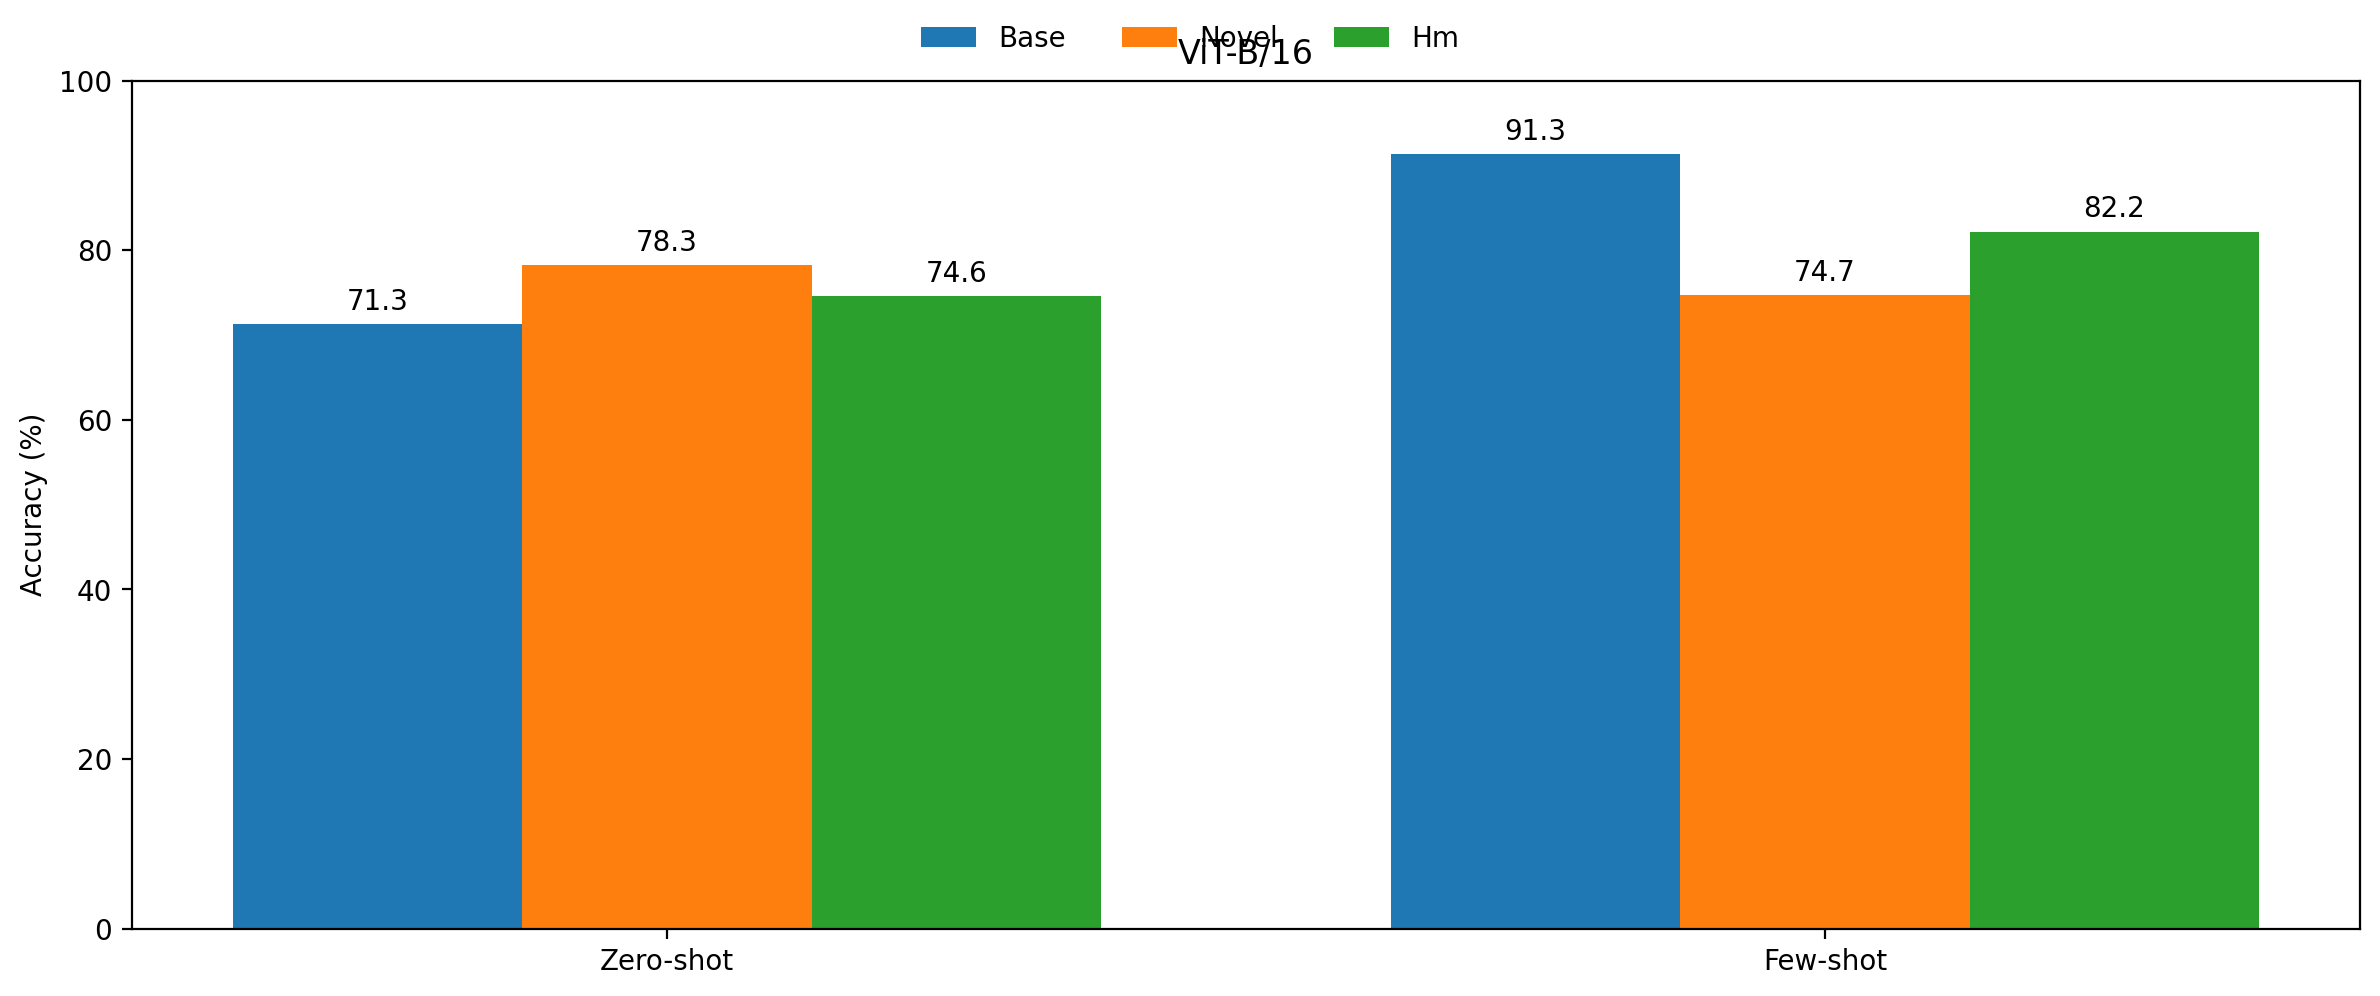

In [13]:
plot_data, base_predictions, novel_predictions = main()
display_evaluation_results(plot_data)

In [14]:
# Let's check the results on tensorboard
%load_ext tensorboard
%tensorboard --logdir=runs

In [15]:
# Compact Confusion Matrix on "Most Important" Classes
# Assumes: VIT16_CLIP_MODEL, DEVICE, CLASS_NAMES, base_predictions, novel_predictions already in scope.
# If y_true_* not built yet, this cell will reconstruct them (no retraining).
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# ==== Config ====
target_split = "novel"
selection_mode = "hardest"
K = 12
normalize_cm = True
pairs_per_class = 2
thumb_size = (96, 96)
figure_dpi = 220

tensor_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((112, 112)),
    torchvision.transforms.ToTensor()
])
_, _, test_raw = get_data(transform=tensor_transform)
base_classes, novel_classes = base_novel_categories(test_raw)
test_base, test_novel = split_data(test_raw, base_classes)

loader_base = torch.utils.data.DataLoader(test_base,
                                          batch_size=32,
                                          shuffle=False,
                                          num_workers=4)
loader_novel = torch.utils.data.DataLoader(test_novel,
                                           batch_size=32,
                                           shuffle=False,
                                           num_workers=4)


def build_y_true(loader):
    classes = [clazz.cpu().numpy() for _, clazz in loader]
    return np.concatenate(classes)


y_true_base = build_y_true(loader_base)
y_true_novel = build_y_true(loader_novel)

# ==== Full confusion matrices (rows=true, cols=pred) ====
labels_base = base_classes
labels_novel = novel_classes


Loading Flowers102 dataset


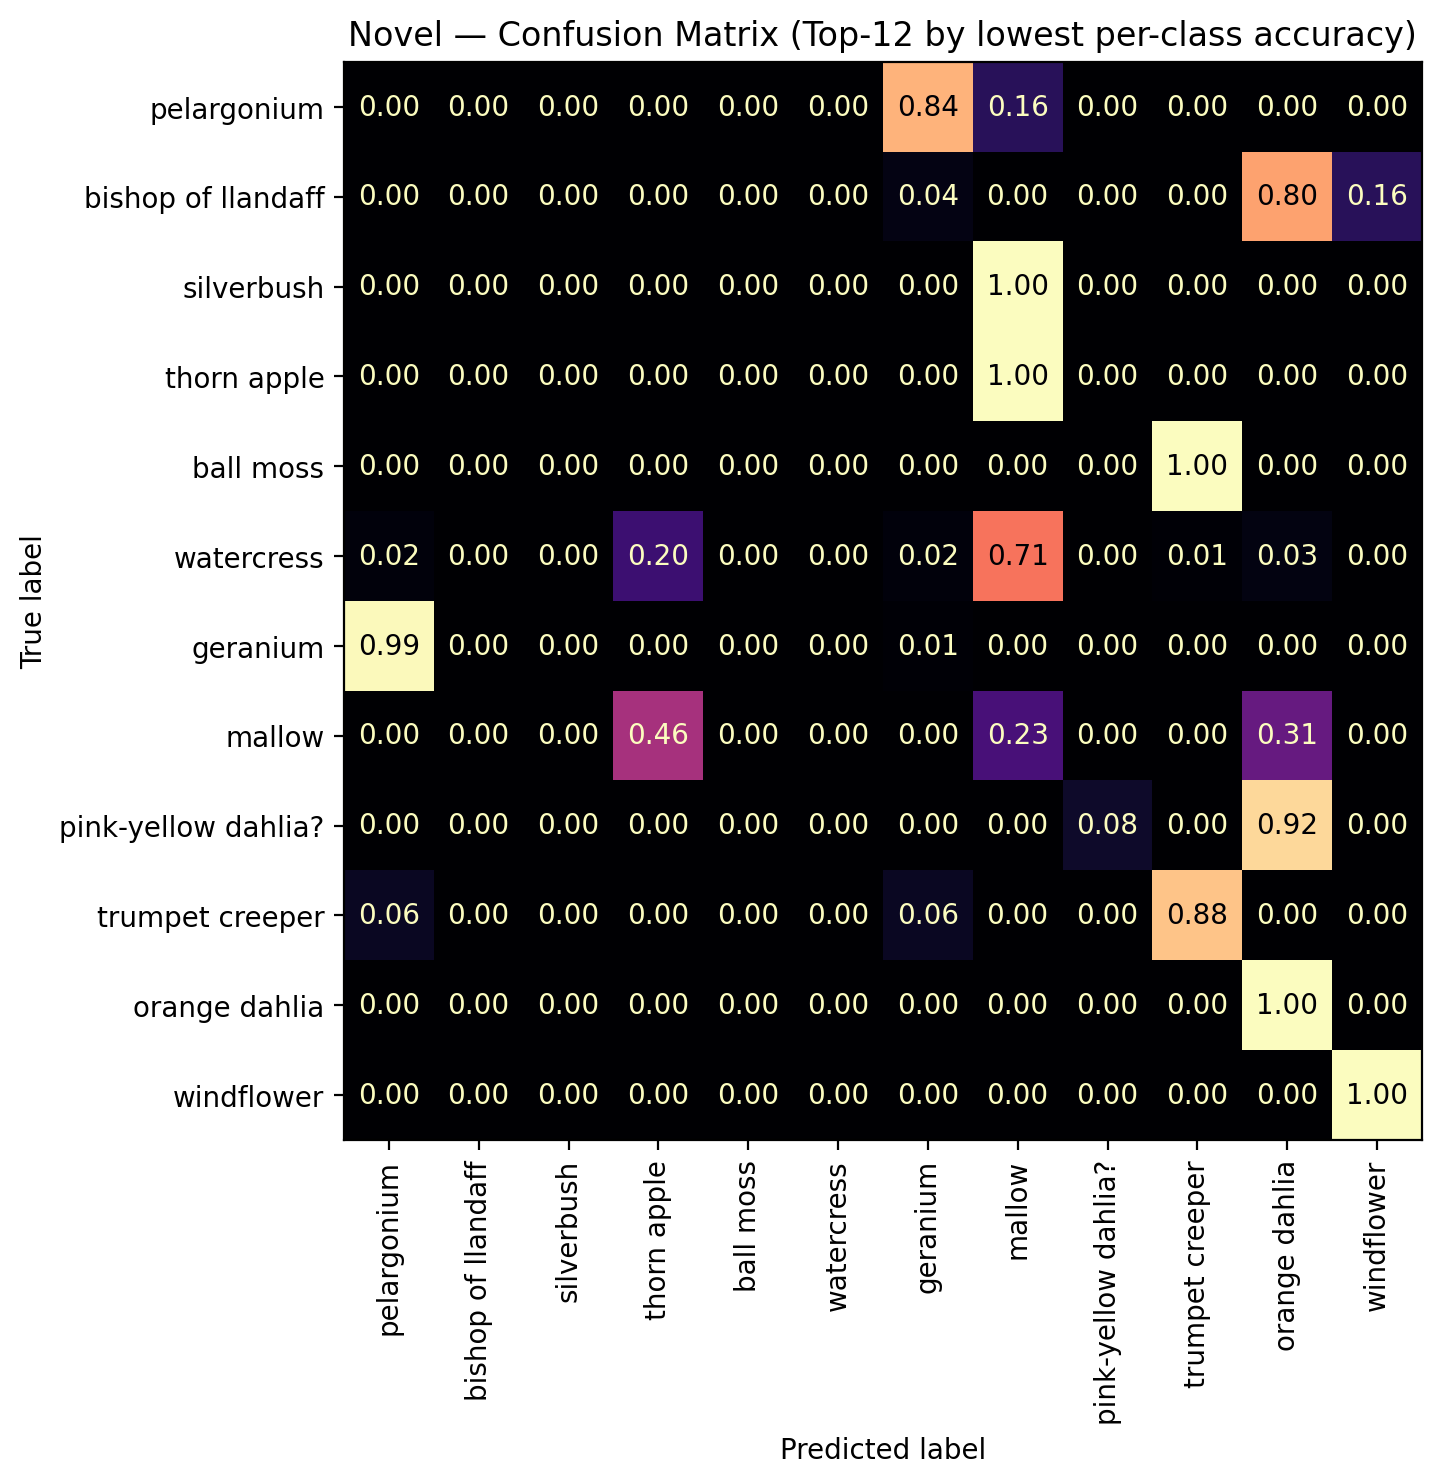

In [16]:
# ==== Config ====
target_split = "novel"  # "base" or "novel"
selection_mode = "hardest"  # "hardest" | "impact" | "pairs"
K = 12  # number of classes to display (8–16 works well)
normalize_cm = True  # normalize rows for readability


def _to_np(x):
    if torch.is_tensor(x):
        x = x.detach().cpu().numpy()
    return np.asarray(x).reshape(-1)


def _get_y(split):
    d = base_predictions if split == "base" else novel_predictions
    assert isinstance(d, dict) and "true" in d and "pred" in d, "Expected dict with keys 'true' and 'pred'."
    y_true = _to_np(d["true"])
    y_pred = _to_np(d["pred"])
    assert len(y_true) == len(y_pred), "true/pred length mismatch"
    return y_true, y_pred


y_true, y_pred = _get_y(target_split)

# Label index list for the confusion matrix
if "base_classes" in globals() and "novel_classes" in globals():
    label_idx_list = base_classes if target_split == "base" else novel_classes
else:
    # fallback to whatever appears in y_true
    label_idx_list = sorted(np.unique(y_true).tolist())

cm_full = confusion_matrix(y_true, y_pred, labels=label_idx_list)


def _row_norm(cm):
    rs = cm.sum(axis=1, keepdims=True).astype(float)
    rs[rs == 0] = 1.0
    return cm / rs


# ---- Selection strategies ----
def _select_hardest(cm, lbls, k):
    diag = np.diag(cm).astype(float)
    row_sum = cm.sum(axis=1).astype(float);
    row_sum[row_sum == 0] = 1.0
    acc = diag / row_sum
    order = np.argsort(acc)  # ascending -> hardest first
    return [lbls[i] for i in order[:k]], acc


def _select_impact(cm, lbls, k):
    diag = np.diag(cm).astype(float)
    row_sum = cm.sum(axis=1).astype(float)
    impact = row_sum - diag
    order = np.argsort(-impact)  # descending
    return [lbls[i] for i in order[:k]], impact


def _select_pairs(cm, lbls, k):
    off = cm.copy();
    np.fill_diagonal(off, 0)
    sym = off + off.T
    pairs = []
    for i in range(sym.shape[0]):
        for j in range(i + 1, sym.shape[1]):
            if sym[i, j] > 0:
                pairs.append((sym[i, j], i, j))
    pairs.sort(reverse=True)
    picked_pos = []
    used = set()
    for _, i, j in pairs:
        used.update([i, j])
        picked_pos = list(used)
        if len(picked_pos) >= k:
            break
    if len(picked_pos) < k:
        # pad with highest-impact classes
        extra, _ = _select_impact(cm, list(range(len(lbls))), k)
        for pos in extra:
            if pos not in picked_pos:
                picked_pos.append(pos)
            if len(picked_pos) >= k:
                break
    picked_pos = picked_pos[:k]
    return [lbls[i] for i in picked_pos], sym


# Choose mode
if selection_mode == "hardest":
    selected_labels, metric = _select_hardest(cm_full, label_idx_list, K)
    explain = "lowest per-class accuracy"
elif selection_mode == "impact":
    selected_labels, metric = _select_impact(cm_full, label_idx_list, K)
    explain = "highest total errors"
elif selection_mode == "pairs":
    selected_labels, metric = _select_pairs(cm_full, label_idx_list, K)
    explain = "most-confused class pairs"
else:
    raise ValueError("selection_mode must be: 'hardest' | 'impact' | 'pairs'")

# Slice CM to the selected classes (keep original order from label_idx_list)
pos_map = {lbl: i for i, lbl in enumerate(label_idx_list)}
sel_pos = [pos_map[lbl] for lbl in selected_labels]
cm_sub = cm_full[np.ix_(sel_pos, sel_pos)]
cm_plot = _row_norm(cm_sub) if normalize_cm else cm_sub

sel_names = [CLASS_NAMES[lbl] for lbl in selected_labels]
split_name = "Base" if target_split == "base" else "Novel"

fig, ax = plt.subplots(figsize=(7, 7))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_plot, display_labels=sel_names)
disp.plot(ax=ax,
          cmap='magma',
          colorbar=False,
          xticks_rotation=90,
          values_format=".2f" if normalize_cm else "d")
plt.title(f"{split_name} — Confusion Matrix (Top-{len(sel_names)} by {explain})")
plt.show()


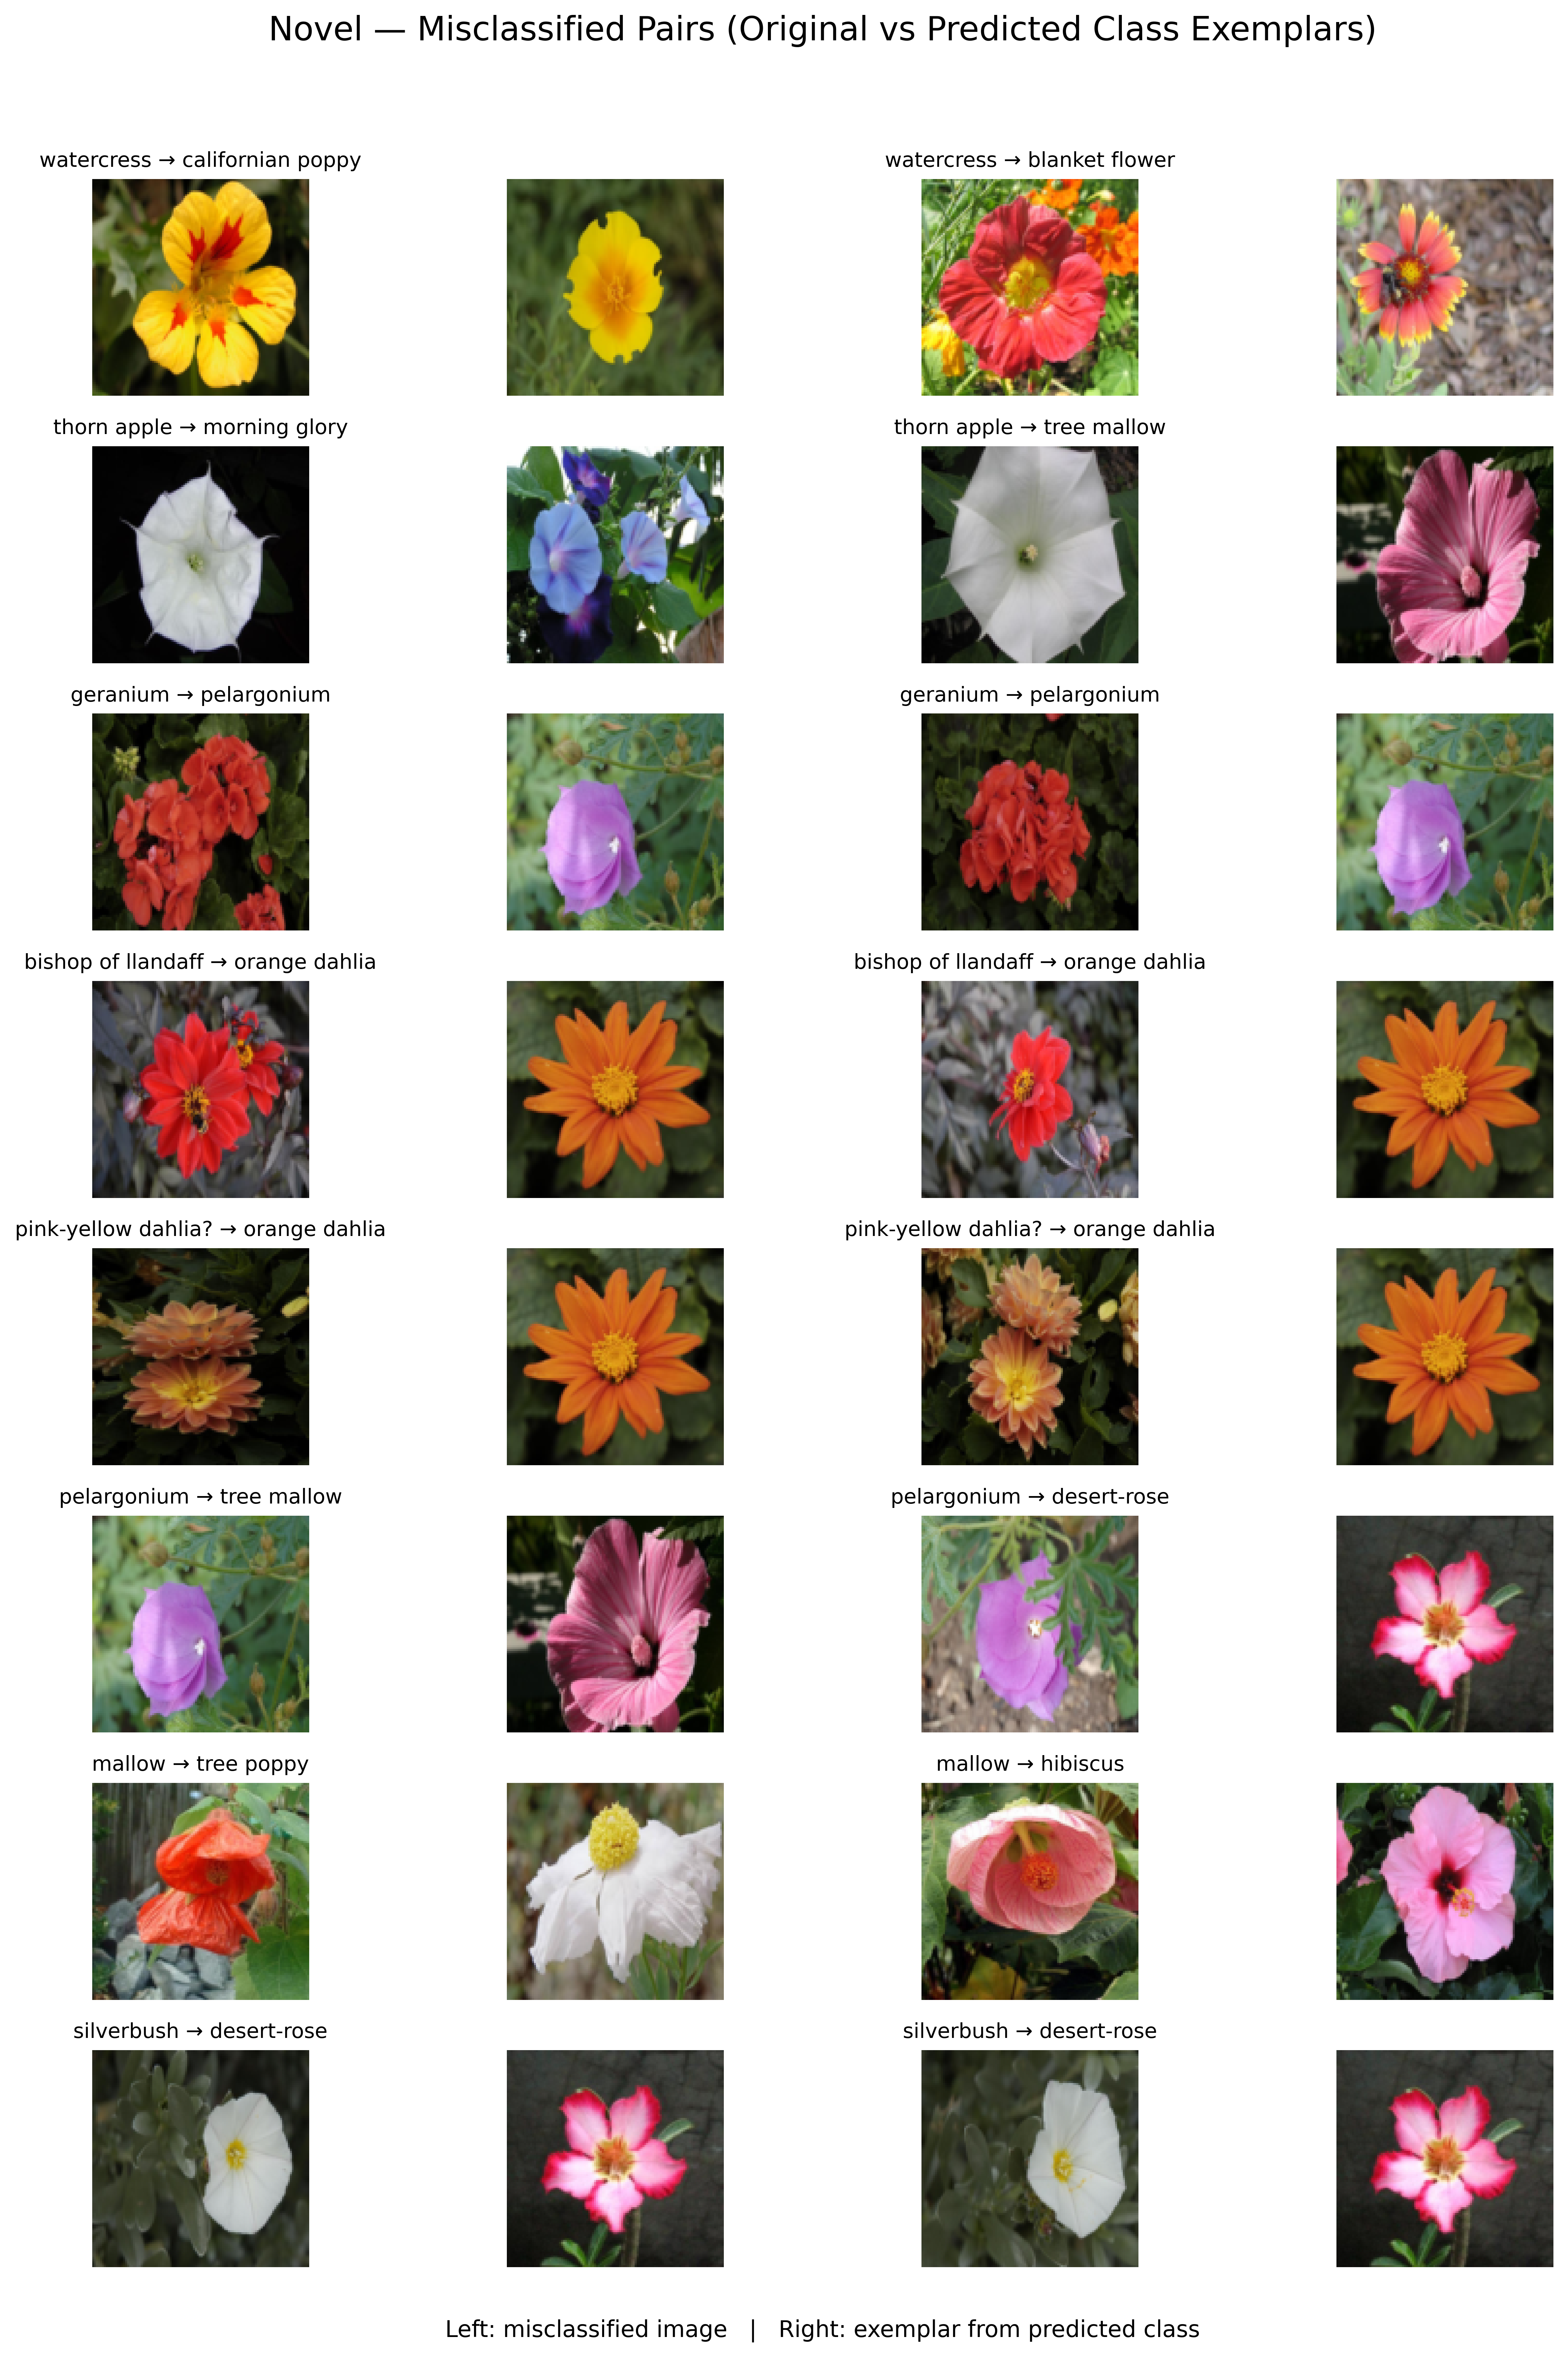

Saved: findings/misclassified_pairs_novel_rgb.png


In [17]:


# Build base/novel class sets (if not provided)
if "base_classes" in globals() and "novel_classes" in globals():
    base_cls, novel_cls = base_classes, novel_classes
else:
    half = len(CLASS_NAMES) // 2
    base_cls = list(range(0, half))
    novel_cls = list(range(half, len(CLASS_NAMES)))

subset_indices = [i for i, y in enumerate(test_raw._labels)
                  if y in (set(base_cls) if target_split == "base" else set(novel_cls))]
assert len(subset_indices) == len(y_true), (
    f"indices={len(subset_indices)} vs preds={len(y_true)} — were preds made on a different split?"
)


K_auto = min(8, len(np.unique(y_true)))
mask_err = (y_true != y_pred)
totals = {int(cls): int(np.sum(mask_err & (y_true == cls))) for cls in np.unique(y_true)}
selected_labels = [c for c, _ in sorted(totals.items(), key=lambda kv: -kv[1])[:K_auto]]

# Map class -> dataset indices for the whole test set (to pick exemplars)
class_to_indices = {}
for idx, cls in enumerate(test_raw._labels):
    class_to_indices.setdefault(int(cls), []).append(idx)

rows = len(selected_labels)
cols = pairs_per_class * 2
fig_w = min(2.0 * cols + 4, 26)
fig_h = min(1.6 * rows + 3, 30)
fig, axs = plt.subplots(rows, cols, figsize=(fig_w, fig_h), dpi=figure_dpi, squeeze=False)

for r, cls_idx in enumerate(selected_labels):
    cls_idx = int(cls_idx)
    # positions where GT==cls but Pred!=cls (this class's mistakes)
    err_pos = np.where((y_true == cls_idx) & (y_pred != cls_idx))[0]
    take = err_pos[:pairs_per_class]

    for k in range(pairs_per_class):
        axL = axs[r, 2 * k]
        axR = axs[r, 2 * k + 1]
        axL.axis("off")
        axR.axis("off")

        if k >= len(take):
            continue

        i = int(take[k])
        ds_idx = subset_indices[i]
        true_cls = int(y_true[i])
        pred_cls = int(y_pred[i])

        # Left: misclassified image (RGB)
        img_L, _ = test_raw[ds_idx]
        axL.imshow(img_L.permute(1, 2, 0))

        # Right: exemplar from predicted class (RGB)
        cand = class_to_indices.get(pred_cls, [])
        exemplar_idx = next((ci for ci in cand if ci != ds_idx), (cand[0] if cand else ds_idx))
        img_R, _ = test_raw[exemplar_idx]
        axR.imshow(img_R.permute(1, 2, 0))

        # Title on the right cell to save space
        axL.set_title(f"{CLASS_NAMES[true_cls]} → {CLASS_NAMES[pred_cls]}", fontsize=10)

        # Row label once
        if k == 0:
            axL.set_ylabel(CLASS_NAMES[cls_idx], rotation=0, labelpad=50, fontsize=12, va='center')

fig.text(0.5, 0.01,
         "Left: misclassified image   |   Right: exemplar from predicted class",
         ha='center', fontsize=11)

plt.suptitle(f"{target_split.capitalize()} — Misclassified Pairs (Original vs Predicted Class Exemplars)",
             y=0.995, fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.97])

os.makedirs('findings', exist_ok=True)
out_path = f"findings/misclassified_pairs_{target_split}_rgb.png"
plt.savefig(out_path, bbox_inches="tight", dpi=figure_dpi)
plt.show()
print(f"Saved: {out_path}")
